In [1]:
import torch, math, os, sys, re, scipy
import neurokit2 as nk
from tqdm import tqdm
import pandas as pd
from scipy import signal
%matplotlib inline
sys.path.append("../..")
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
data_org = "/home/zhangyuanyuan/Dataset/data_MMECG/data_org/"

In [3]:
f_org = 200
def mat2df():
    """
    Read .mat file from original MMECG dataset to a pandas dataframe.
    """
    # ID is the index of data files, Obj_ID is the index for actual person under test
    columnnames = ['ID', 'Obj_ID', 'RCG', 'ECG', 'posXYZ',
                   'gender', 'age', 'physistatus']
    df = pd.DataFrame(columns=columnnames)
    df.loc[0, columnnames] = [1, 2, 3, 4, 5, 6, 7, 8]

    for ID in range(1, 92):
        data = scipy.io.loadmat('/home/zhangyuanyuan/Dataset/data_MMECG/data_org/'+str(ID)+'.mat')
        Obj_ID= data['data'][0]['id'].squeeze()
        RCG = np.array([i for i in data['data'][0]['RCG']]).squeeze().transpose()
        ECG = np.array([i for i in data['data'][0]['ECG']]).squeeze()
        posXYZ = np.array([i for i in data['data'][0]['posXYZ']]).squeeze()
        gender = data['data'][0]['gender'].squeeze()
        age = data['data'][0]['age'].squeeze()
        physistatus = data['data'][0]['physistatus'].squeeze()

        df.loc[ID-1, columnnames] = [ID, int(Obj_ID),RCG,
                                    ECG, posXYZ, gender, int(age), physistatus]
    return df
# Bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y


In [4]:
df=mat2df() # read all the .mat file to dataframe


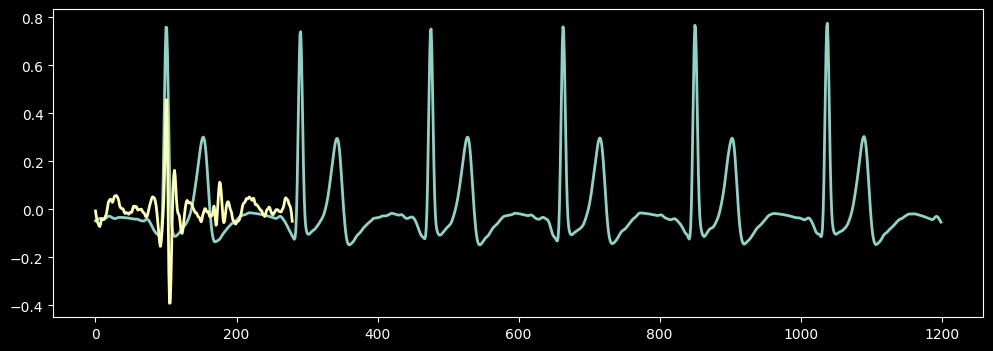

In [5]:
ID = 1
offset = 25
start = 0
end = 1500
radar_sig = df.RCG[ID][0][200:2400]
ecg = df.ECG[ID][200+offset:1400+offset]
radar_sig_T = butter_bandpass_filter(radar_sig, 20,25,f_org, order=6) #BPF for radar signal
radar_sig_R = butter_bandpass_filter(radar_sig, 5,15,f_org, order=6) #BPF for radar signal
# radar_sig_plot = radar_sig[start:end]
# radar_sig_R_plot = radar_sig_R[start+offset:end+offset]
plt.figure(figsize=(12,4))
plt.plot((ecg),linewidth=2)
plt.plot((radar_sig[:280]),linewidth=2)
plt.style.use('default')
# plt.plot((radar_sig_T),linewidth=2)
# plt.plot((radar_sig_R),linewidth=2)



In [6]:
# coherent non-coherent in dynamic
# binary hypothesis test

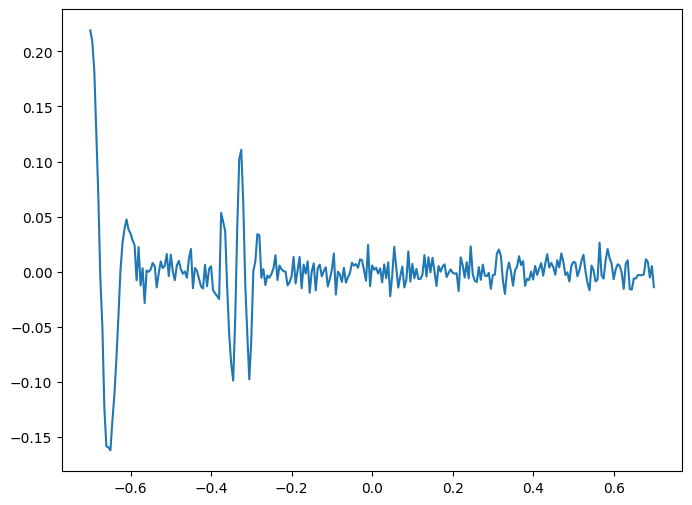

In [7]:
dt=.005
fs=1/dt
n=140*2
t=np.linspace(-n/2,n/2,n+1)*dt
a1=0.22
a2=0.12
mu_1=-0.69
mu_2=-0.33
sigma_1=0.05
variance_1=sigma_1**2
sigma_2=0.03
variance_2=sigma_2**2
db=0.01
f1 = 10
f2= 23
xt_1=np.cos(2*np.pi*t*f1)*a1*np.exp(-(t-mu_1)**2/(2*variance_1))
xt_2=np.cos(2*np.pi*t*f2)*a2*np.exp(-(t-mu_2)**2/(2*variance_2))
noise=np.random.normal(0,db,n+1)
xt=xt_1-xt_2+noise

plt.figure(figsize=(8,6))
plt.plot(t,xt,label='simulated signal')
# plt.plot(t,radar_sig,label='radar signal')

[ 5.05145853e-01  9.75940796e-02 -2.05559422e-01  1.69309963e-01
  3.87713622e-02  3.14891029e-02  1.04315113e-02  9.87441386e+00
  2.18994602e+01]


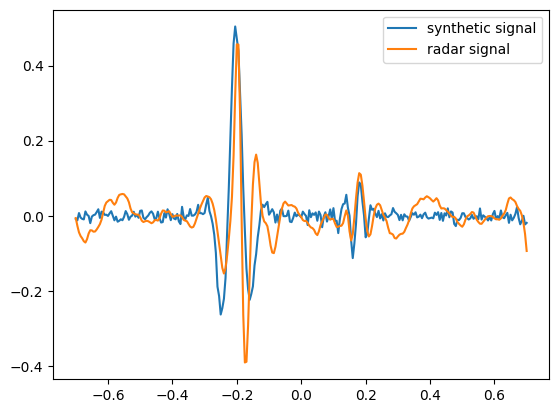

In [8]:
# given the signal model as xt, with the variable a1,a2,mu_1,mu_2,sigma_1,sigma_2.
# using scipy.optimize to minimize the error between radar_sig and the signal model
# the error is defined as the RMSE between radar_sig and the signal model
import scipy.optimize as opt
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

def fun(x):
    a1,a2,mu_1,mu_2,sigma_1,sigma_2, db, f1, f2 = x
    xt_1=np.cos(2*np.pi*t*f1)*a1*np.exp(-(t-mu_1)**2/(2*sigma_1**2))
    xt_2=np.cos(2*np.pi*t*f2)*a2*np.exp(-(t-mu_2)**2/(2*sigma_2**2))
    noise=np.random.normal(0,db,n+1)
    xt=xt_1+xt_2+noise
    # return correlation coefficient
    return -np.corrcoef(radar_sig[:281],xt)[0,1]
    # return np.sqrt(np.mean((radar_sig[:281]-xt)**2))

x0 = [0.5,0.1,-0.16,0.18,0.05,0.03, 0.01, 10, 23]
res = minimize(fun, x0, method='Nelder-Mead', tol=1e-6)
a1,a2,mu_1,mu_2,sigma_1,sigma_2, db, f1, f2 = res.x
# a1,a2,mu_1,mu_2,sigma_1,sigma_2, db, f1, f2 = x0
print(res.x)
xt_1=np.cos(2*np.pi*t*f1)*a1*np.exp(-(t-mu_1)**2/(2*sigma_1**2))
xt_2=np.cos(2*np.pi*t*f2)*a2*np.exp(-(t-mu_2)**2/(2*sigma_2**2))
noise=np.random.normal(0,db,n+1)
xt=xt_1+xt_2+noise
plt.plot(t,xt,label='synthetic signal')
plt.plot(t,radar_sig[:281],label='radar signal')
plt.legend()